<a href="https://colab.research.google.com/github/Adithyanjohnson/damage-part-detection/blob/main/conformfeb24maskrccn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall torchvision -y
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html --force-reinstall
!pip install Pillow==9.5.0
!pip install numpy==1.23.5
# Uninstall current torchvision first to avoid conflicts


# Reinstall torchvision with the correct CUDA version
!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl (6.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0+cu118 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/MyDrive/datasetfinal/archive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-install-ab4yuaeu/detectron2_e2cb3435c578492f8f9d338be6da1b7e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-ab4yuaeu/detectron2_e2cb3435c578492f8f9d338be6da1b7e
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464
  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py) ... done


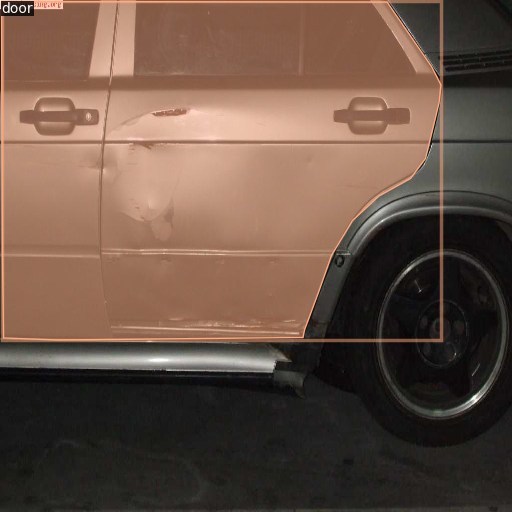

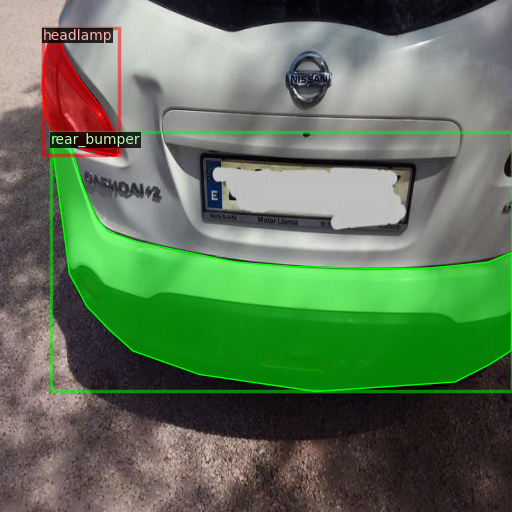

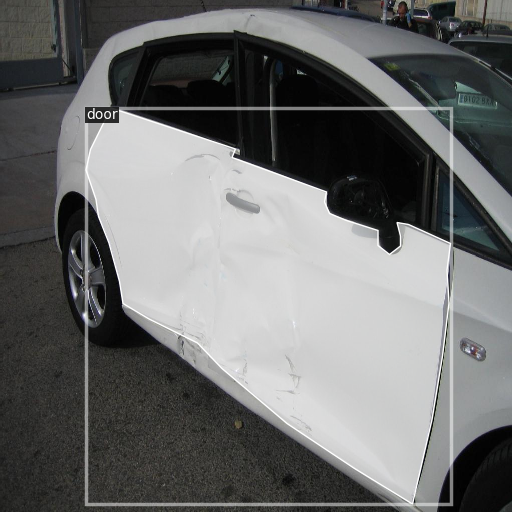

In [ ]:
import os
import numpy as np
import json
# Restart kernel after running the pip install command
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git@v0.6#egg=detectron2'
from detectron2 import model_zoo # Import after installation and kernel restart
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from google.colab.patches import cv2_imshow
import cv2
import random



if "car_dd_train" not in DatasetCatalog:
    register_coco_instances("car_dd_train", {}, f"{dataset_path}/train/COCO_mul_train_annos.json", f"{dataset_path}/train")
if "car_dd_val" not in DatasetCatalog:
    register_coco_instances("car_dd_val", {}, f"{dataset_path}/val/COCO_mul_val_annos.json", f"{dataset_path}/val")

# Load metadata
car_dd_metadata = MetadataCatalog.get("car_dd_train")
dataset_dicts = DatasetCatalog.get("car_dd_train")

# Visualize random samples
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dd_train",)
cfg.DATASETS.TEST = ("car_dd_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 500  # Increase for better training  default 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Adjust based on your dataset

# Output directory
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Set device to CPU
cfg.MODEL.DEVICE = "cpu" # This line tells Detectron2 to use CPU



In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[02/06 06:27:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 143MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[02/06 06:27:42 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/06 06:40:54 d2.utils.events]:  eta: 5:10:29  iter: 19  total_loss: 3.199  loss_cls: 1.617  loss_box_reg: 0.8083  loss_mask: 0.6922  loss_rpn_cls: 0.07927  loss_rpn_loc: 0.02346  time: 39.0188  data_time: 0.0493  lr: 9.7405e-05  
[02/06 06:52:54 d2.utils.events]:  eta: 4:50:15  iter: 39  total_loss: 2.447  loss_cls: 0.8767  loss_box_reg: 0.692  loss_mask: 0.6755  loss_rpn_cls: 0.08206  loss_rpn_loc: 0.02667  time: 37.4296  data_time: 0.0112  lr: 0.00019731  
[02/06 07:05:04 d2.utils.events]:  eta: 4:37:09  iter: 59  total_loss: 2.407  loss_cls: 0.7772  loss_box_reg: 0.9042  loss_mask: 0.642  loss_rpn_cls: 0.01882  loss_rpn_loc: 0.01789  time: 37.1049  data_time: 0.0112  lr: 0.0002972  
[02/06 07:17:32 d2.utils.events]:  eta: 4:25:08  iter: 79  total_loss: 2.236  loss_cls: 0.7193  loss_box_reg: 0.8841  loss_mask: 0.5871  loss_rpn_cls: 0.02333  loss_rpn_loc: 0.01836  time: 37.1790  data_time: 0.0122  lr: 0.00039711  
[02/06 07:30:05 d2.utils.events]:  eta: 4:11:58  iter: 99  total_los

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate on the validation dataset
evaluator = COCOEvaluator("car_dd_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dd_val")
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)


WARNING [02/06 11:40:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/06 11:40:16 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/MyDrive/datasetfinal/archive/val/COCO_mul_val_annos.json
[02/06 11:40:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/06 11:40:16 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[02/06 11:40:16 d2.data.common]: Serialized dataset takes 0.01 MiB
[02/06 11:40:16 d2.evaluation.evaluator]: Start inference on 11 batches
[02/06 11:40:34 d2.evaluation.evaluator]: Inference done 1/11. Dataloading: 1.4025 s/iter. Inference: 16.7115 s/iter. Eval: 0.0155 s/iter. Total: 18.1328 s/iter. ETA=0:03:01
[02/06 11:40:41 d2.evaluation.evaluator]: Inference done 2/11. Dataloading: 0.7018 s/

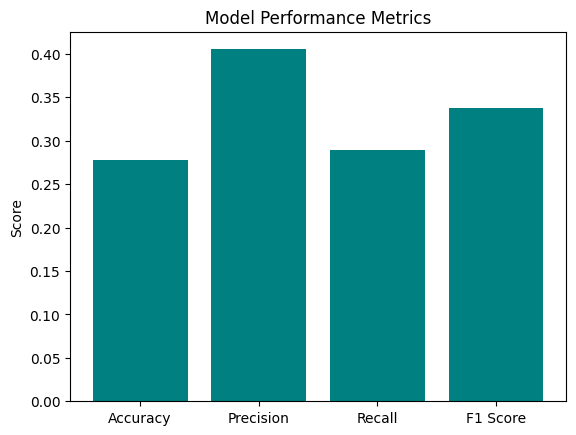

In [ ]:
import matplotlib.pyplot as plt

# Extract relevant metrics
precision = evaluation_results["bbox"]["AP50"] / 100
recall = evaluation_results["bbox"]["AP75"] / 100
accuracy = evaluation_results["bbox"]["AP"] / 100
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Visualization
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1_score}
plt.bar(metrics.keys(), metrics.values(), color='teal')
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()


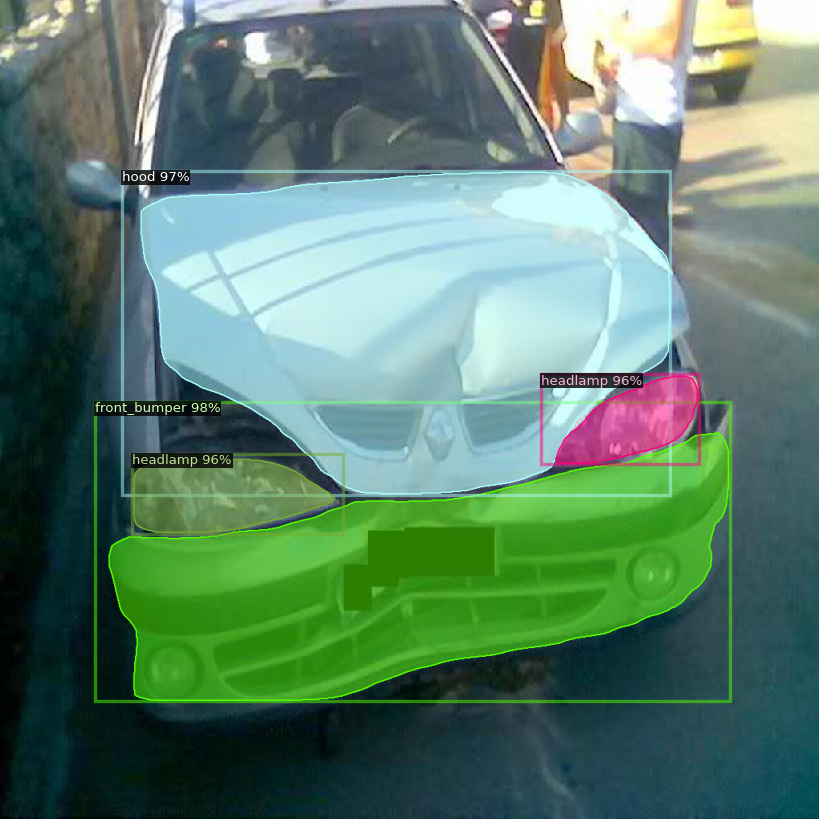

In [ ]:
sample_image_path = f"/content/drive/MyDrive/datasetfinal/archive/train/52.jpg"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    outputs = predictor(img)

    # Visualize predictions
    v = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
else:
    print(f"Error: Image file not found at {sample_image_path}")


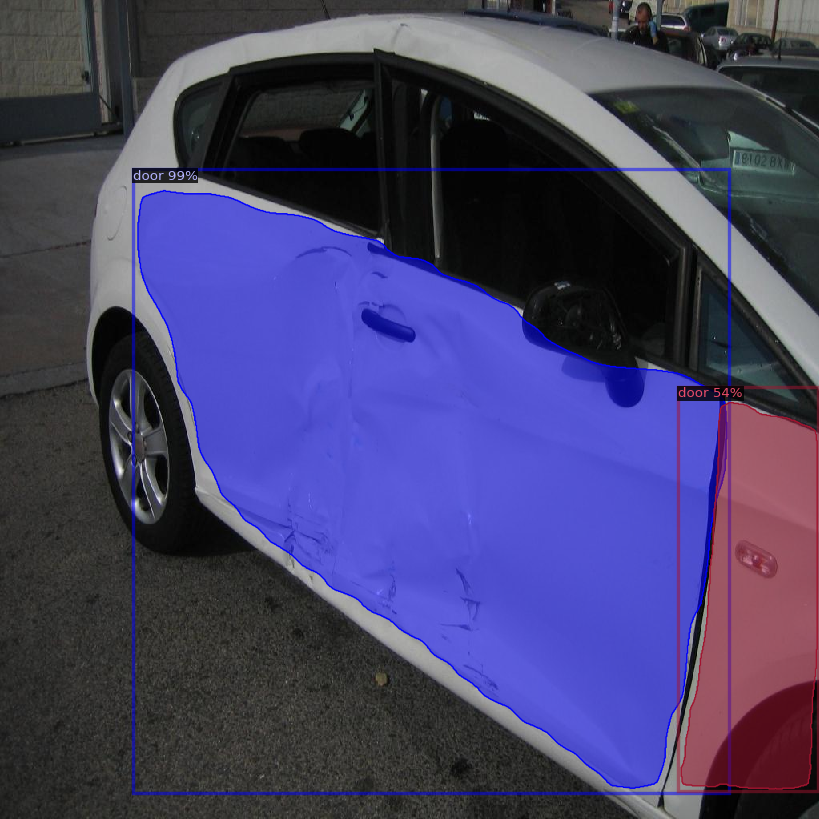

Damage 1:
  - Area: Middle
  - Damage Severity: Severe
  - Damage Percentage: 98.62%
Damage 2:
  - Area: Back
  - Damage Severity: Severe
  - Damage Percentage: 54.10%


In [ ]:
# Function to determine the damaged area based on bounding box location
def get_damage_area(bbox, img_shape):
    img_height, img_width = img_shape[:2]
    x_min, y_min, x_max, y_max = bbox

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    if y_center < img_height / 3:
        return "Front"
    elif y_center > 2 * img_height / 3:
        return "Back"
    else:
        return "Middle"

# Function to determine severity based on damage percentage
def get_damage_severity(damage_percentage):
    if damage_percentage > 50:
        return "Severe"
    elif 20 < damage_percentage <= 50:
        return "Medium"
    else:
        return "Small"

# Load and predict on a sample image
sample_image_path = f"/content/drive/MyDrive/datasetfinal/archive/train/18.jpg"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    outputs = predictor(img)

    # Extract instances
    instances = outputs["instances"].to("cpu")
    pred_boxes = instances.pred_boxes.tensor.numpy()
    pred_masks = instances.pred_masks.numpy() if instances.has("pred_masks") else None
    scores = instances.scores.numpy()

    # Visualize predictions
    v = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.8)
    v = v.draw_instance_predictions(instances)

    cv2_imshow(v.get_image()[:, :, ::-1])

    # Iterate over detections
    for i, box in enumerate(pred_boxes):
        damage_area = get_damage_area(box, img.shape)
        damage_percentage = scores[i] * 100  # Approximate damage percentage
        damage_severity = get_damage_severity(damage_percentage)

        print(f"Damage {i+1}:")
        print(f"  - Area: {damage_area}")
        print(f"  - Damage Severity: {damage_severity}")
        print(f"  - Damage Percentage: {damage_percentage:.2f}%")
else:
    print(f"Error: Image file not found at {sample_image_path}")


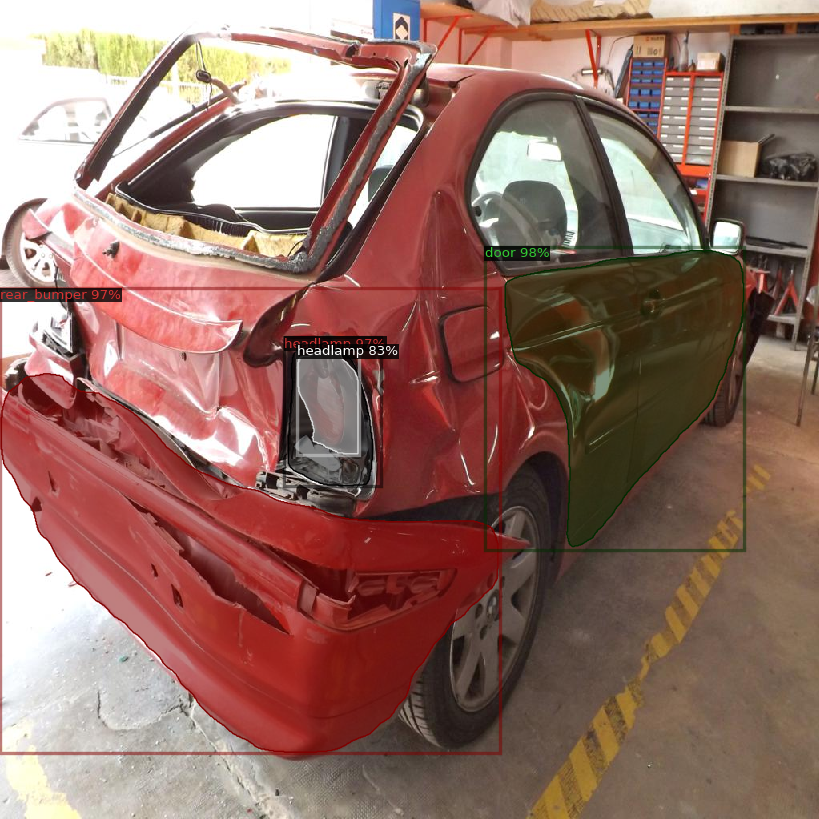

Damage Type: door, Damage Percentage: 98.47%, Estimated Repair Cost: ₹0
Damage Type: rear_bumper, Damage Percentage: 96.75%, Estimated Repair Cost: ₹0
Damage Type: headlamp, Damage Percentage: 96.56%, Estimated Repair Cost: ₹0
Damage Type: headlamp, Damage Percentage: 83.36%, Estimated Repair Cost: ₹0


In [ ]:
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

# Function to estimate repair cost
def estimate_repair_cost(damage_type, damage_percentage):
    # Repair cost ranges (in INR)
    cost_ranges = {
        "scratch": (1000, 3000),
        "crack": (5000, 15000),
        "dent": (3000, 8000),
        "flat_tire": (1500, 5000),
    }

    # Estimate cost based on damage type and percentage
    if damage_type in cost_ranges:
        min_cost, max_cost = cost_ranges[damage_type]
        # The cost will scale with the damage percentage (assuming 100% damage means max cost)
        estimated_cost = min_cost + (max_cost - min_cost) * (damage_percentage / 100)
        return round(estimated_cost, 2)
    return 0

# Path to the image for prediction
sample_image_path = f"/content/drive/MyDrive/datasetfinal/archive/train/30.jpg"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    outputs = predictor(img)

    # Visualize predictions
    v = Visualizer(img[:, :, ::-1], metadata=car_dd_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

    # Extract damage types and their respective areas
    instances = outputs["instances"].to("cpu")
    damage_info = []
    for i in range(len(instances)):
        damage_type = car_dd_metadata.get("thing_classes")[instances.pred_classes[i]]
        damage_percentage = instances.scores[i].item() * 100  # This gives us a rough "confidence" score for damage extent

        # Estimate the repair cost for this damage type and percentage
        repair_cost = estimate_repair_cost(damage_type, damage_percentage)

        # Append damage info to list
        damage_info.append({
            "Damage Type": damage_type,
            "Damage Percentage": round(damage_percentage, 2),
            "Estimated Repair Cost (INR)": repair_cost
        })

    # Output the damage information
    for info in damage_info:
        print(f"Damage Type: {info['Damage Type']}, Damage Percentage: {info['Damage Percentage']}%, Estimated Repair Cost: ₹{info['Estimated Repair Cost (INR)']}")

else:
    print(f"Error: Image file not found at {sample_image_path}")
